# Hit Maker Predictor

Model Objective: Predict whether a song will chart on Billboard using musical and promotional features.

## Initialisation

Import packages and perform data cleaning

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from dmba import textDecisionTree
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV # Create the parameter grid based on the results of random search 
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error


import matplotlib.pyplot as plt
%matplotlib inline 
# tells VS Code to display plots inside the interface

## Data Cleaning

In [3]:
# Import main dataset
spotify_df = pd.read_csv("spotify_2023_peak_cleaned.csv")

# Identify problematic rows
invalid_streams = spotify_df[~spotify_df['streams'].str.replace(',', '').str.isnumeric()]
print(invalid_streams[['track_name', 'streams']])

                              track_name  \
574  Love Grows (Where My Rosemary Goes)   

                                               streams  
574  BPM110KeyAModeMajorDanceability53Valence75Ener...  


In [4]:
# Drop the problematic row by index
spotify_df = spotify_df.drop(index=574).reset_index(drop=True)

In [5]:
# Convert cleaned string to int (remove commas if any)
for col in ['streams', 'in_deezer_playlists', 'in_shazam_charts']:
    spotify_df[col] = spotify_df[col].astype(str).str.replace(',', '').str.replace('–', '0')
    spotify_df[col] = pd.to_numeric(spotify_df[col], errors='coerce').fillna(0).astype(int)

## Exploratory data analysis (EDA)

In [6]:
#EDA

spotify_df.info()

spotify_df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            952 non-null    object 
 1   artist(s)_name        952 non-null    object 
 2   artist_count          952 non-null    int64  
 3   released_year         952 non-null    int64  
 4   released_month        952 non-null    int64  
 5   released_day          952 non-null    int64  
 6   in_spotify_playlists  952 non-null    int64  
 7   in_spotify_charts     952 non-null    int64  
 8   streams               952 non-null    int64  
 9   in_apple_playlists    952 non-null    int64  
 10  in_apple_charts       952 non-null    int64  
 11  in_deezer_playlists   952 non-null    int64  
 12  in_deezer_charts      952 non-null    int64  
 13  in_shazam_charts      952 non-null    int64  
 14  bpm                   952 non-null    int64  
 15  key                   8

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,...,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,charted_billboard,days_to_peak
count,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,9.520000e+02,952.000000,952.000000,952.000000,...,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000
mean,1.556723,2018.288866,6.038866,13.944328,5202.565126,12.022059,5.141374e+08,67.866597,51.963235,385.535714,...,122.553571,66.984244,51.406513,64.274160,27.078782,1.582983,18.214286,10.138655,0.551471,1549.838235
std,0.893331,11.011397,3.564571,9.197223,7901.400683,19.582405,5.668569e+08,86.470591,50.628850,1131.078760,...,28.069601,14.631282,23.480526,16.558517,26.001599,8.414064,13.718374,9.915399,0.497605,3924.050074
min,1.000000,1930.000000,1.000000,1.000000,31.000000,0.000000,2.762000e+03,0.000000,0.000000,0.000000,...,65.000000,23.000000,4.000000,9.000000,0.000000,0.000000,3.000000,2.000000,0.000000,0.000000
25%,1.000000,2020.000000,3.000000,6.000000,874.500000,0.000000,1.416362e+08,13.000000,7.000000,13.000000,...,99.750000,57.000000,32.000000,53.000000,6.000000,0.000000,10.000000,4.000000,0.000000,46.000000
50%,1.000000,2022.000000,6.000000,13.000000,2216.500000,3.000000,2.905309e+08,34.000000,38.500000,44.000000,...,121.000000,69.000000,51.000000,66.000000,18.000000,0.000000,12.000000,6.000000,1.000000,296.500000
75%,2.000000,2022.000000,9.000000,22.000000,5573.750000,16.000000,6.738690e+08,88.000000,87.000000,164.250000,...,140.250000,78.000000,70.000000,77.000000,43.000000,0.000000,24.000000,11.000000,1.000000,850.750000
max,8.000000,2023.000000,12.000000,31.000000,52898.000000,147.000000,3.703895e+09,672.000000,275.000000,12367.000000,...,206.000000,96.000000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000,1.000000,29935.000000


/var/folders/wr/pk6811g13_57c07xqk29wvkm0000gn/T/ipykernel_77686/2029753180.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  output_fig = sns.countplot(y='charted_billboard', data=spotify_df, palette=custom_palette)
/var/folders/wr/pk6811g13_57c07xqk29wvkm0000gn/T/ipykernel_77686/2029753180.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  output_fig.set_yticklabels(['No', 'Yes'], fontsize=11)


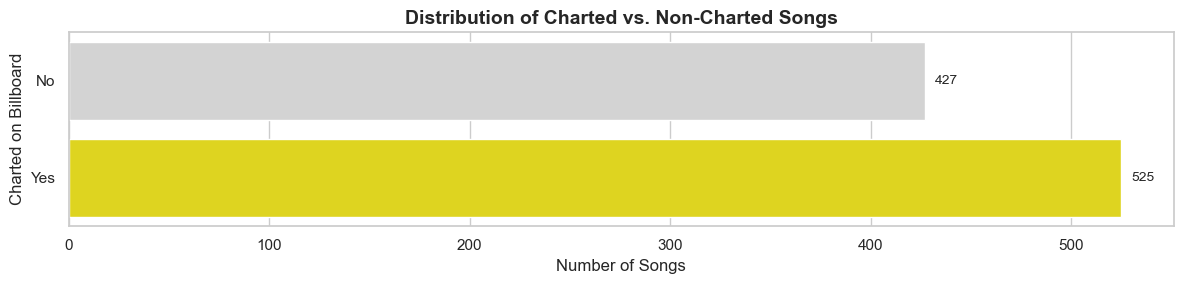

In [11]:
# Counting the output variable

# Define the theme
sns.set(style="whitegrid", palette="pastel")

# Define a custom color palette
custom_palette = {'0': "#d3d3d3", '1': "#fef100"}  # grey for 'not charted', Spotify green for 'charted'

plt.figure(figsize=(12, 3))
output_fig = sns.countplot(y='charted_billboard', data=spotify_df, palette=custom_palette)
output_fig.set_title("Distribution of Charted vs. Non-Charted Songs", fontsize=14, fontweight='bold')
output_fig.set_ylabel("Charted on Billboard", fontsize=12)
output_fig.set_xlabel("Number of Songs", fontsize=12)
output_fig.set_yticklabels(['No', 'Yes'], fontsize=11)

# Add counts on top of bars
for p in output_fig.patches:
    width = p.get_width()
    output_fig.text(width + 5, p.get_y() + p.get_height()/2, f'{int(width)}',
            ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# define target (y1) columns
# Target variable
y1cols = ['charted_billboard']
y1 = spotify_df[y1cols]

## Model 1: Full Feature Model (18 variables)

This model uses all relevant predictors 
Goal: Maximize performance using the full picture

In [12]:
# define predictor (X1) columns
X1cols_model1 = [
    'in_spotify_playlists', 'in_spotify_charts', 'streams',
    'in_apple_playlists', 'in_apple_charts',
    'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts',
    'bpm', 'danceability_%', 'valence_%', 'energy_%',
    'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%',
    'artist_count', 'days_to_peak'
]
X1 = spotify_df[X1cols_model1]

<Axes: >

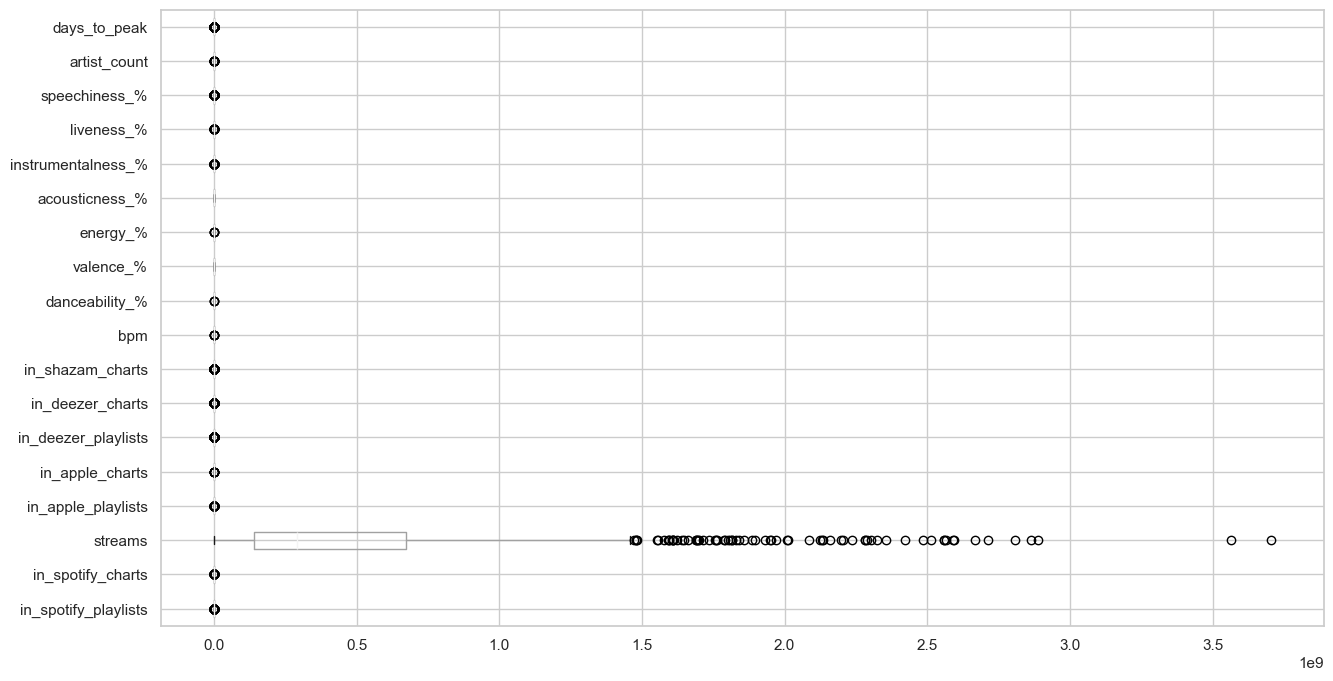

In [13]:
# EDA
X1_numeric_data = X1.select_dtypes(include=[np.number])
X1_numeric_data.boxplot(vert=False,figsize=(15,8))


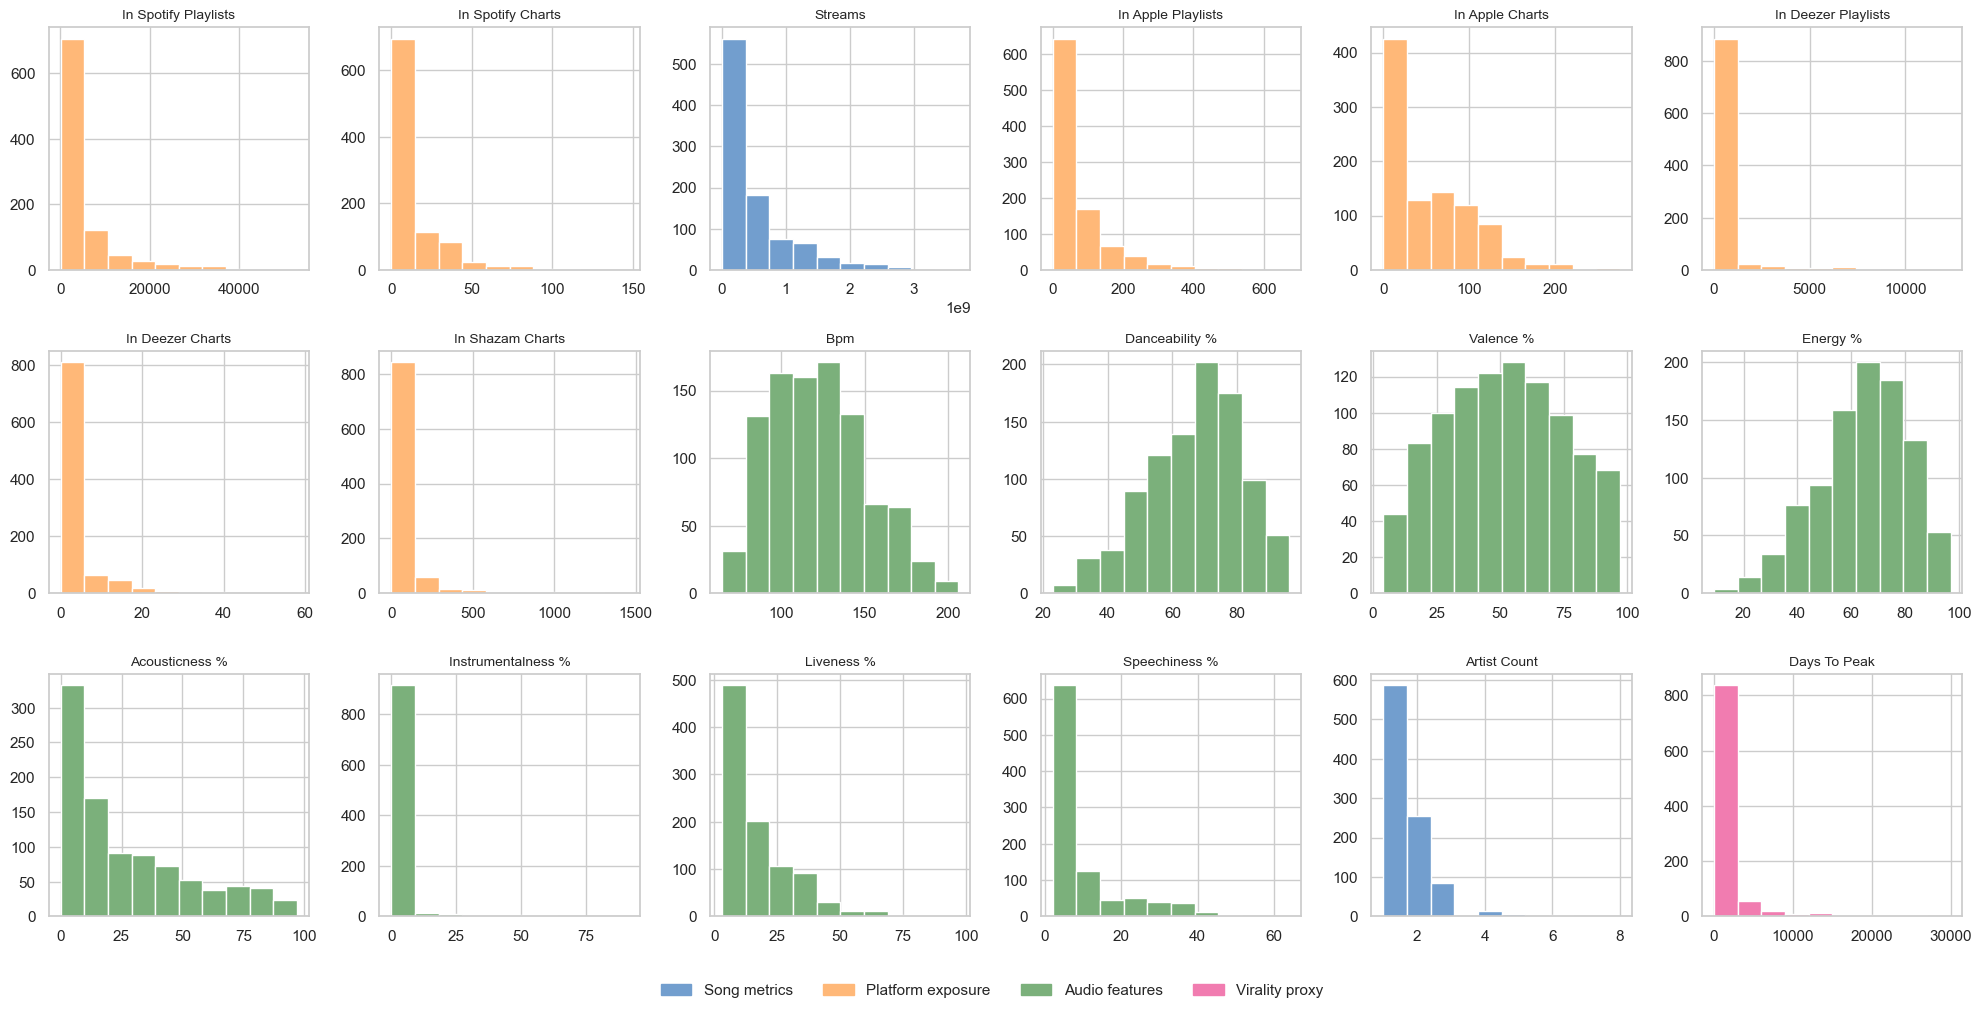

In [34]:
# Create a dictionary to assign colours by category
color_map = {
    'Song metrics': '#729ECE',      
    'Platform exposure': '#FFB878', 
    'Audio features': '#7BB07B',     
    'Virality proxy': '#F17CB0'    
}

# Define categories for each variable
categories = {
    'Song metrics': ['streams', 'artist_count'],
    'Platform exposure': [
        'in_spotify_playlists', 'in_spotify_charts',
        'in_apple_playlists', 'in_apple_charts',
        'in_deezer_playlists', 'in_deezer_charts',
        'in_shazam_charts'
    ],
    'Audio features': [
        'bpm', 'danceability_%', 'valence_%', 'energy_%',
        'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'
    ],
    'Virality proxy': ['days_to_peak']
}

# Colour plot background by variable category
var_colors = {}
for cat, vars_in_cat in categories.items():
    for var in vars_in_cat:
        var_colors[var] = color_map[cat]

legend_patches = [mpatches.Patch(color=color_map[cat], label=cat.title()) for cat in color_map]

# Define theme
plt.style.use('ggplot') 
sns.set(style="whitegrid", palette="pastel")

# Plot
predict_fig, predict_axes = plt.subplots(3, 6, figsize=(20, 10))
axes = predict_axes.flatten()

for idx, col in enumerate(X1.columns):
    color = var_colors.get(col, '#e0e0e0')
    X1[col].hist(ax=axes[idx], color=color, edgecolor='white')
    axes[idx].set_title(col.replace('_', ' ').title(), fontsize=10)

# Hide any unused subplots
for j in range(len(X1.columns), len(axes)):
    predict_fig.delaxes(axes[j])

legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
predict_fig.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=4, frameon=False)

plt.tight_layout(rect=[0, 0.03, 1, 1])  
plt.show()


/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


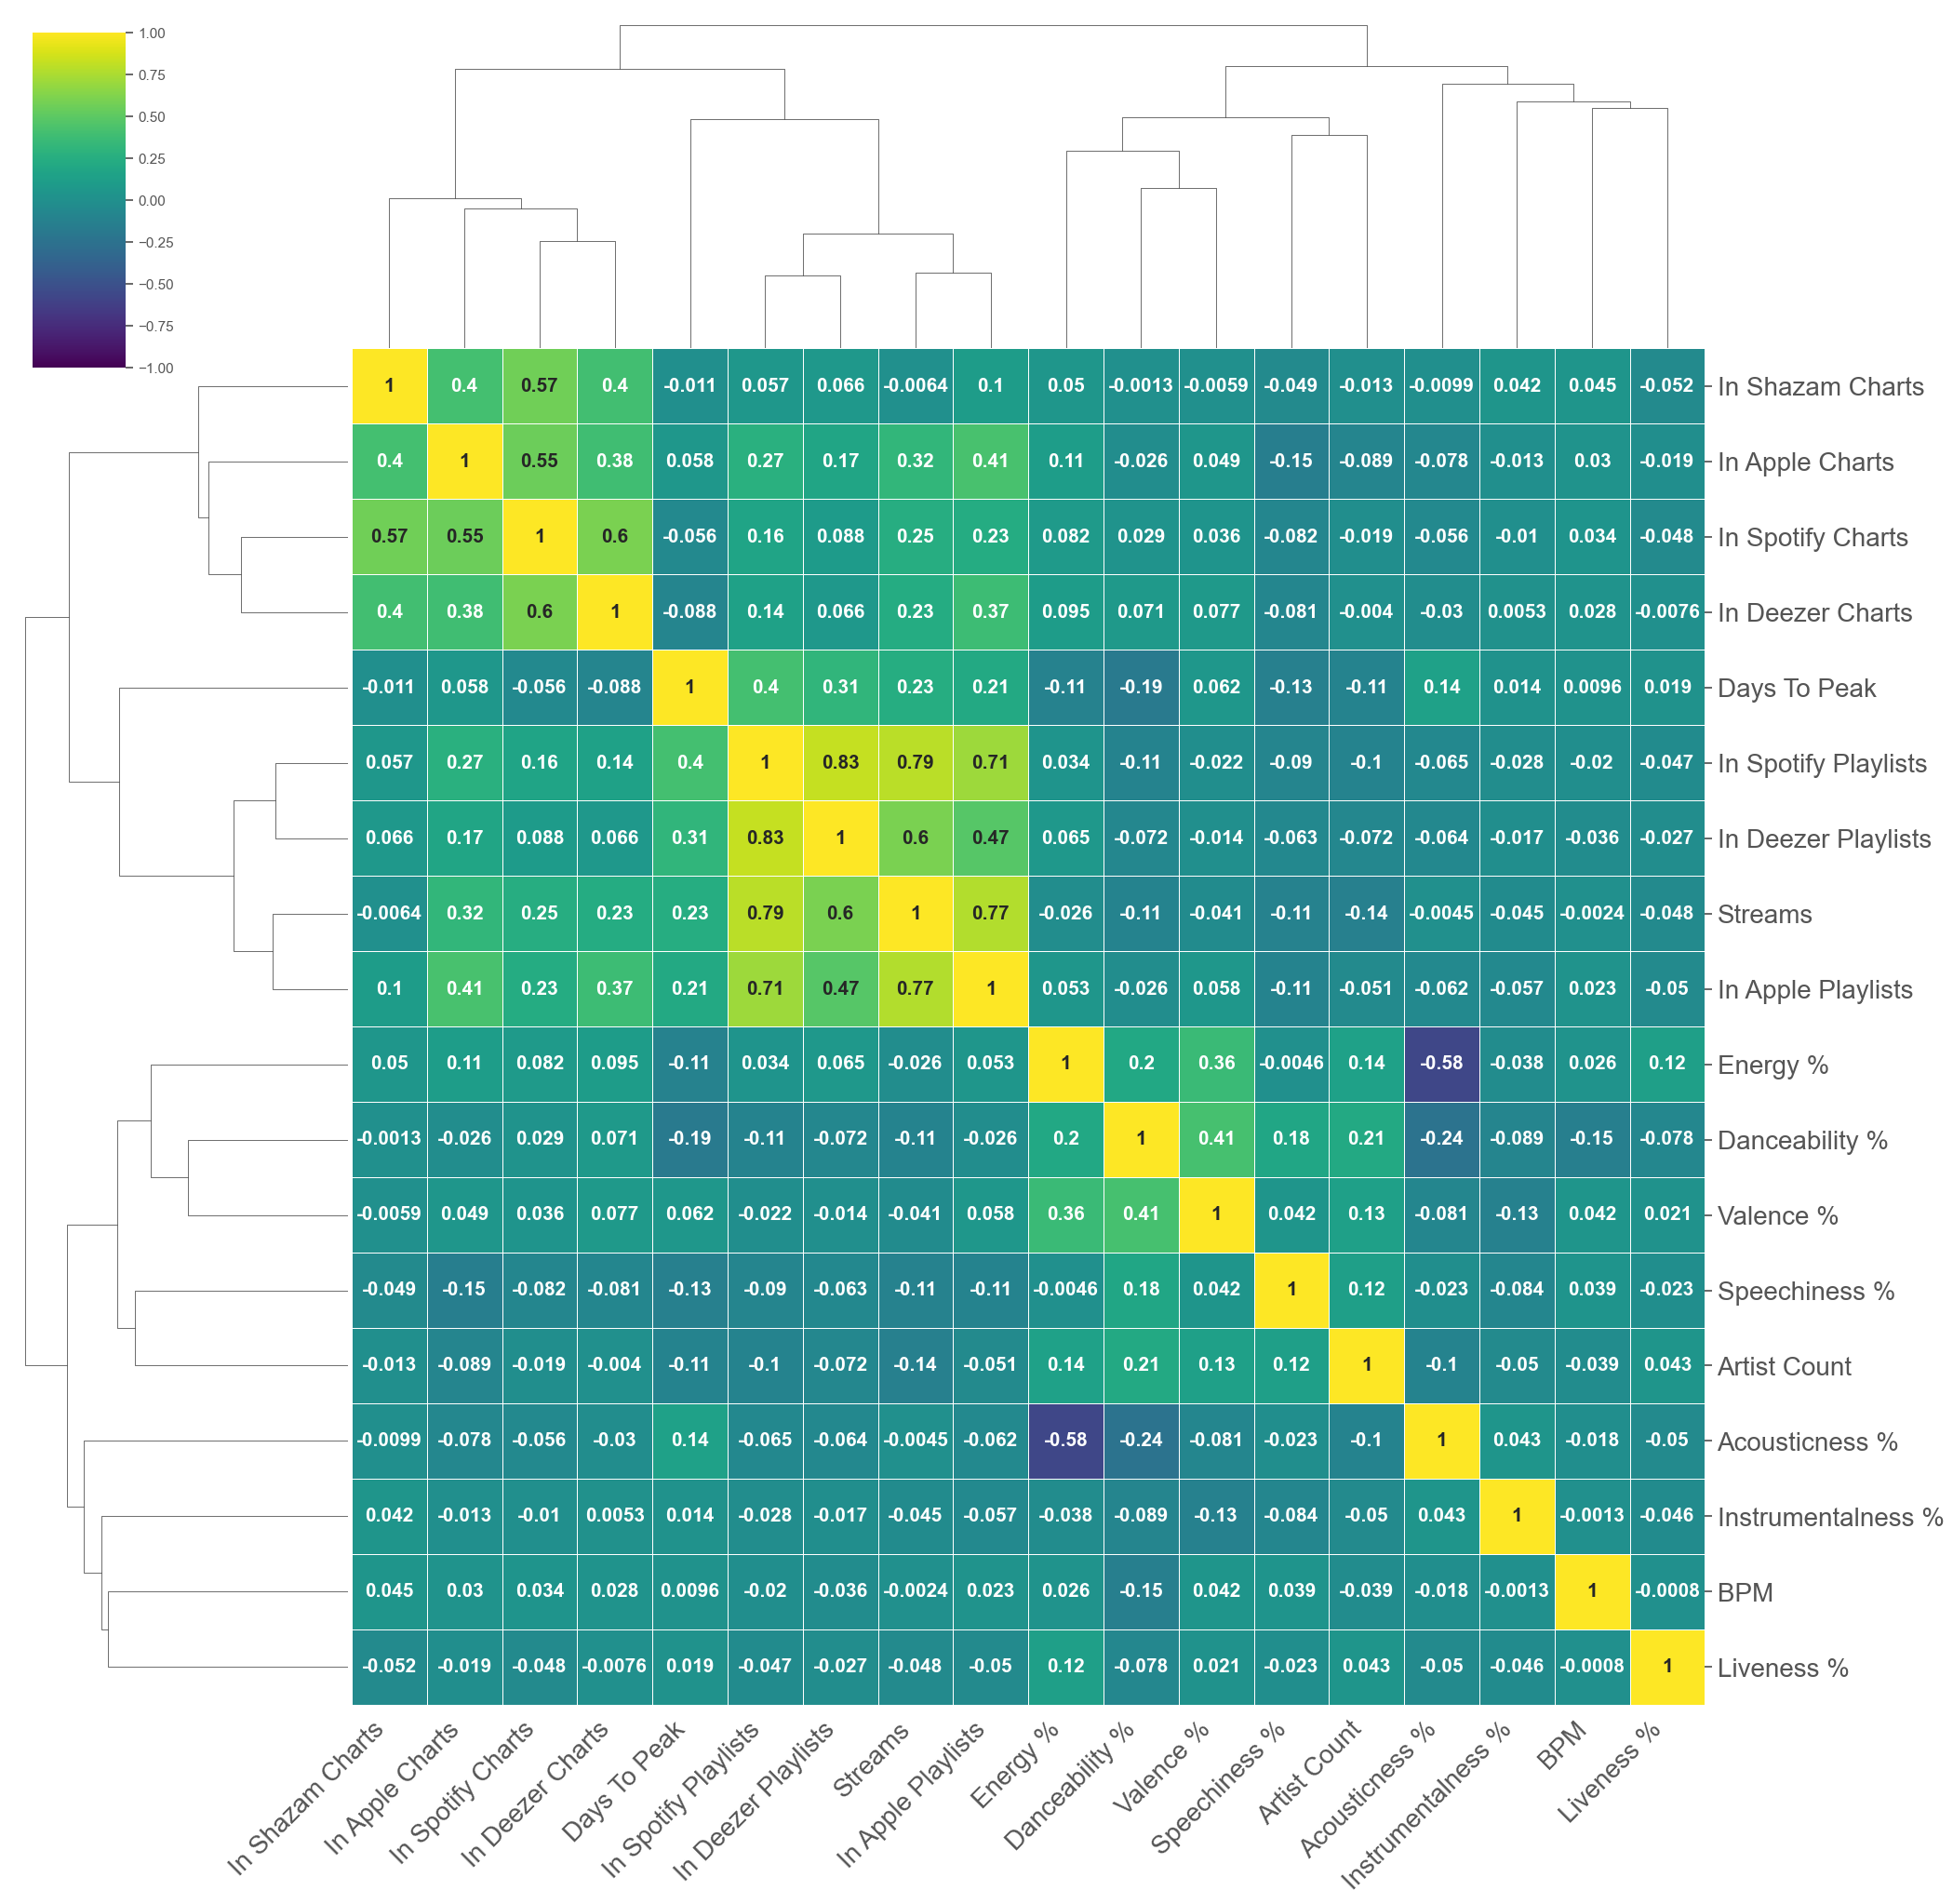

In [19]:
# Calculate correlation matrix between all variables. Defaults to Pearson's r correlation
corr = X1.corr()

# Hierarchically-clustered heatmap of correlation matrix to understand the association between variables
# Nicely formatted variable labels
label_map = {
    'streams': 'Streams',
    'artist_count': 'Artist Count',
    'in_spotify_playlists': 'In Spotify Playlists',
    'in_spotify_charts': 'In Spotify Charts',
    'in_apple_playlists': 'In Apple Playlists',
    'in_apple_charts': 'In Apple Charts',
    'in_deezer_playlists': 'In Deezer Playlists',
    'in_deezer_charts': 'In Deezer Charts',
    'in_shazam_charts': 'In Shazam Charts',
    'bpm': 'BPM',
    'danceability_%': 'Danceability %',
    'valence_%': 'Valence %',
    'energy_%': 'Energy %',
    'acousticness_%': 'Acousticness %',
    'instrumentalness_%': 'Instrumentalness %',
    'liveness_%': 'Liveness %',
    'speechiness_%': 'Speechiness %',
    'days_to_peak': 'Days To Peak'
}

# calculate correlation matrix between all variables. Defaults to Pearson's r correlation
corr = X1.corr()
corr_renamed = corr.rename(index=label_map, columns=label_map)

# hierarchically-clustered heatmap of correlation matrix to understand the association between variables
g = sns.clustermap(corr_renamed, center=0,cmap=plt.get_cmap('viridis'),
            square=True, linewidths=.5, annot=True, vmin=-1, vmax=1,
            annot_kws={"size": 15, "weight": "bold"},
            figsize=(20, 20)) 

# Set font sizes for x and y tick labels
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=20)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=20)

# Rotate x labels for clarity
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right')

plt.show()

## Model 2: Reduced Feature Model (5 variables)
Uses a subset of variables based on Exploratory Data Analysis findings and logic, considering what labels might look at -- playlists & virality.

Goal: Retain performance with fewer inputs to reduce noise and improve interpretability.

In [16]:
X1cols_model2 = [
    'in_spotify_playlists', #A good proxy for Spotify promotion reach
    'in_shazam_charts', #Only weakly correlated with other features, radio promotion proxy
    'artist_count', #may indicate collaborative buzz
    'danceability_%', 'valence_%', #Capture musical feel, likely valuable for hits
    'days_to_peak' #may reflect TikTok or viral timing
]
X2 = spotify_df[X1cols_model2]

<Axes: >

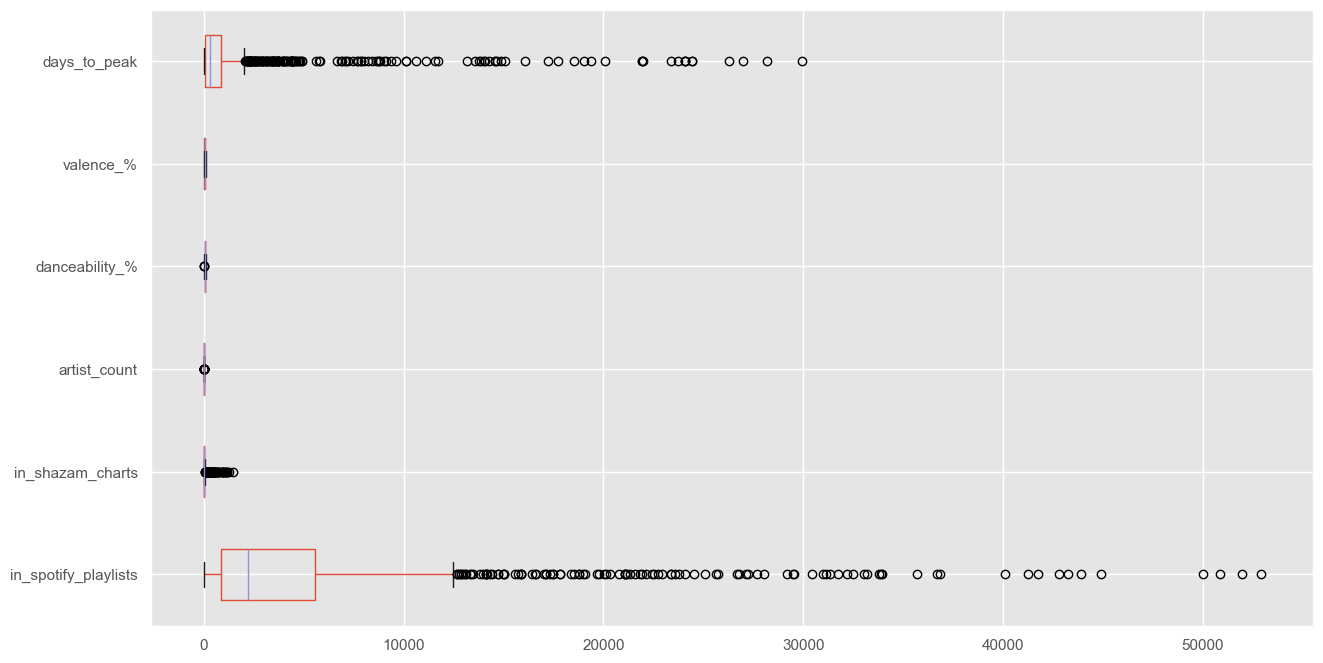

In [17]:
# EDA
X2_numeric_data = X2.select_dtypes(include=[np.number])
X2_numeric_data.boxplot(vert=False,figsize=(15,8))

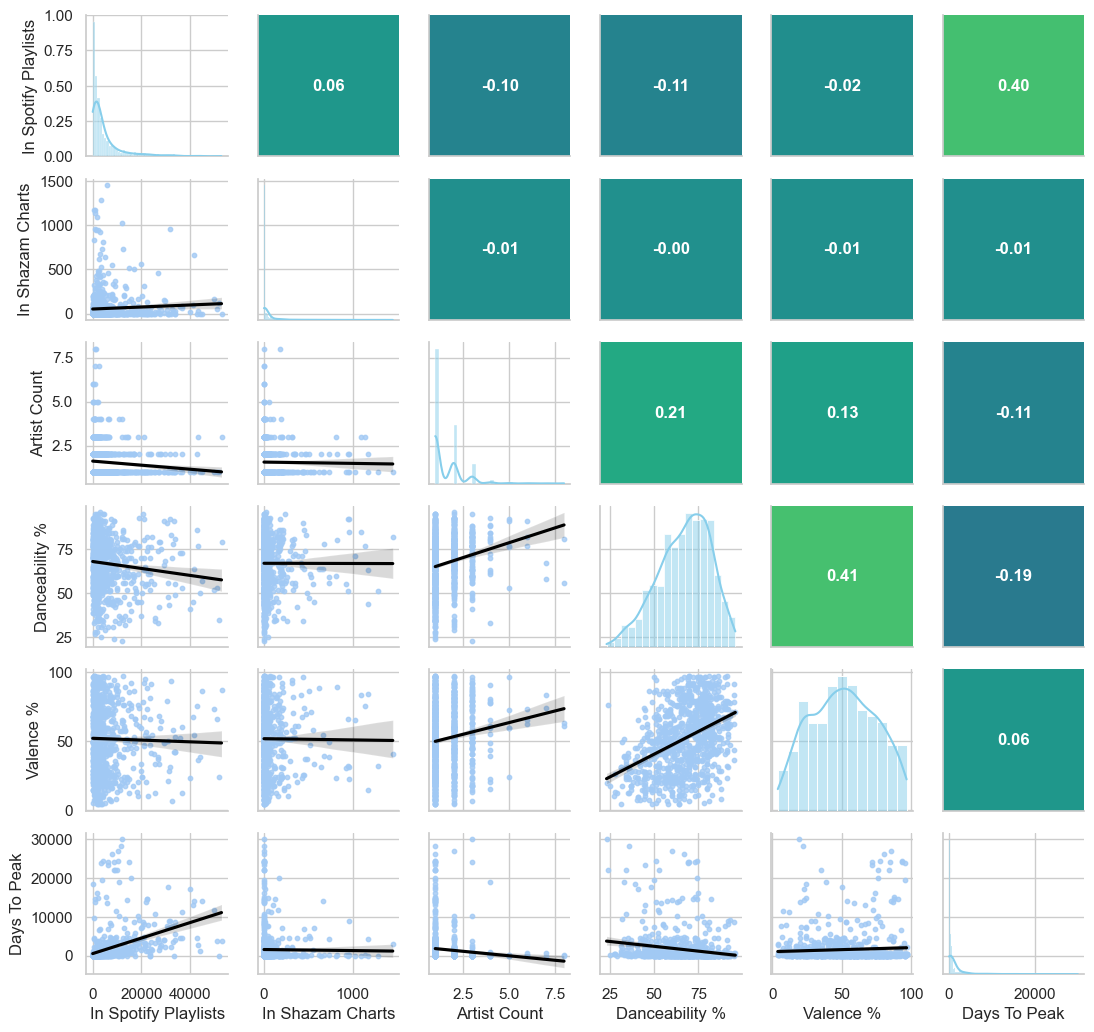

In [35]:
# Making a correlation heatmap diagram for the reduced set variables 

sns.set(style="whitegrid", palette="pastel")

def corrfunc_heatmap(x, y, **kws):
    r = np.corrcoef(x, y)[0, 1]
    ax = plt.gca()
    ax.grid(False)
    # Set background color based on correlation
    cmap = plt.get_cmap("viridis")
    ax.set_facecolor(cmap((r + 1) / 2))  # normalize r to [0,1]
    ax.annotate(f"{r:.2f}", xy=(0.5, 0.5), xycoords=ax.transAxes,
                ha='center', va='center', fontsize=12, color='white', fontweight='bold')

def custom_pairplot_with_heatmap(df, vars_to_plot):
    renamed_df = df[vars_to_plot].rename(columns=label_map)
    g = sns.PairGrid(renamed_df, diag_sharey=False, height= 1.75, aspect=1.05)
    g.map_upper(corrfunc_heatmap)  # upper = heatmap + corr
    g.map_lower(sns.regplot, scatter_kws={'s': 10}, line_kws={'color': 'black'})  # lower = scatter+trend
    g.map_diag(sns.histplot, kde=True, color='skyblue')  # diagonal = hist
    plt.show()

custom_pairplot_with_heatmap(spotify_df, X1cols_model2)

## Model Comparison

In [22]:
#  Model 1: Full Feature Set 
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)


In [23]:
param_grid = {
    'max_depth': [10, 20, 30, 40],
    'n_estimators': [100, 200, 300, 400, 500]
}
# Create a based model
model = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 3 # number of folds for cross validation
                           , n_jobs = -1 # use all processors
                            , verbose = 2 # what to display
                          )

grid_search.fit(X1_train, y1_train)
model1 = grid_search.best_estimator_
y1_pred=model1.predict(X1_test)
print("Model 1 (Full Feature Set)")
print("Best Parameters:", model1)
print ('The out of sample test accuracy for a RandomForestClassifier is : '+ str(round(accuracy_score(y1_test, y1_pred),3)))
print ('MSE: ',mean_squared_error(y1_test, y1_pred))
print ('R2: ', r2_score(y1_test, y1_pred))
print(classification_report(y1_test, y1_pred))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 

[CV] END .....................max_depth=10, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.2s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.3s


/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 

[CV] END .....................max_depth=10, n_estimators=300; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=300; total time=   0.4s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=10, n_estimators=300; total time=   0.4s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s


/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 

[CV] END .....................max_depth=10, n_estimators=400; total time=   0.6s
[CV] END .....................max_depth=10, n_estimators=400; total time=   0.6s
[CV] END .....................max_depth=10, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.3s


/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 

[CV] END .....................max_depth=10, n_estimators=500; total time=   0.7s
[CV] END .....................max_depth=20, n_estimators=300; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=500; total time=   0.7s
[CV] END .....................max_depth=10, n_estimators=500; total time=   0.7s
[CV] END .....................max_depth=20, n_estimators=300; total time=   0.4s
[CV] END .....................max_depth=30, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=30, n_estimators=100; total time=   0.1s


/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 

[CV] END .....................max_depth=20, n_estimators=300; total time=   0.4s
[CV] END .....................max_depth=30, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=20, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=30, n_estimators=200; total time=   0.3s


/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 

[CV] END .....................max_depth=20, n_estimators=400; total time=   0.6s
[CV] END .....................max_depth=30, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=30, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=500; total time=   0.7s
[CV] END .....................max_depth=20, n_estimators=500; total time=   0.7s
[CV] END .....................max_depth=30, n_estimators=300; total time=   0.4s


/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 

[CV] END .....................max_depth=30, n_estimators=300; total time=   0.4s
[CV] END .....................max_depth=20, n_estimators=500; total time=   0.7s
[CV] END .....................max_depth=40, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=30, n_estimators=300; total time=   0.4s
[CV] END .....................max_depth=40, n_estimators=100; total time=   0.2s
[CV] END .....................max_depth=40, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=30, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=30, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=30, n_estimators=400; total time=   0.6s
[CV] END .....................max_depth=40, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=40, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=40, n_estimators=200; total time=   0.3s
[CV] END ...................

/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 

[CV] END .....................max_depth=30, n_estimators=500; total time=   0.7s
[CV] END .....................max_depth=30, n_estimators=500; total time=   0.7s
[CV] END .....................max_depth=40, n_estimators=300; total time=   0.4s
[CV] END .....................max_depth=40, n_estimators=300; total time=   0.4s
[CV] END .....................max_depth=40, n_estimators=300; total time=   0.3s
[CV] END .....................max_depth=40, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=40, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=40, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=40, n_estimators=500; total time=   0.6s
[CV] END .....................max_depth=40, n_estimators=500; total time=   0.5s
[CV] END .....................max_depth=40, n_estimators=500; total time=   0.5s


/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 1 (Full Feature Set)
Best Parameters: RandomForestClassifier(max_depth=20, n_estimators=300)
The out of sample test accuracy for a RandomForestClassifier is : 0.723
MSE:  0.2774869109947644
R2:  -0.13257999552472577
              precision    recall  f1-score   support

           0       0.69      0.63      0.66        82
           1       0.74      0.79      0.76       109

    accuracy                           0.72       191
   macro avg       0.72      0.71      0.71       191
weighted avg       0.72      0.72      0.72       191



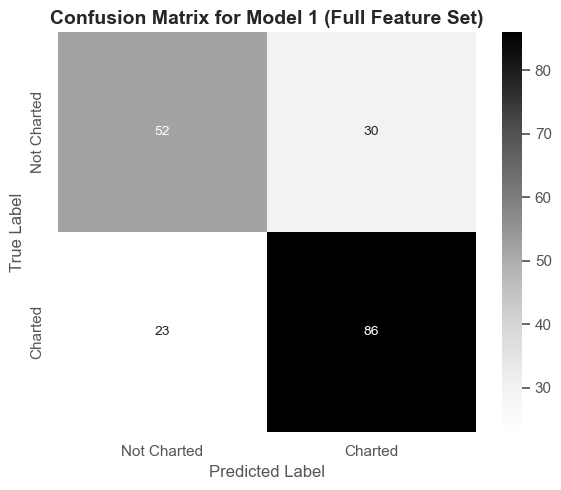

In [24]:
# Confusion matrix
cm = confusion_matrix(y1_test, y1_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys', xticklabels=['Not Charted', 'Charted'], yticklabels=['Not Charted', 'Charted'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix for Model 1 (Full Feature Set)', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

/var/folders/wr/pk6811g13_57c07xqk29wvkm0000gn/T/ipykernel_77686/3665543798.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=feat_df, x='Importance', y='Pretty Name', palette=feat_df['Color'].tolist())


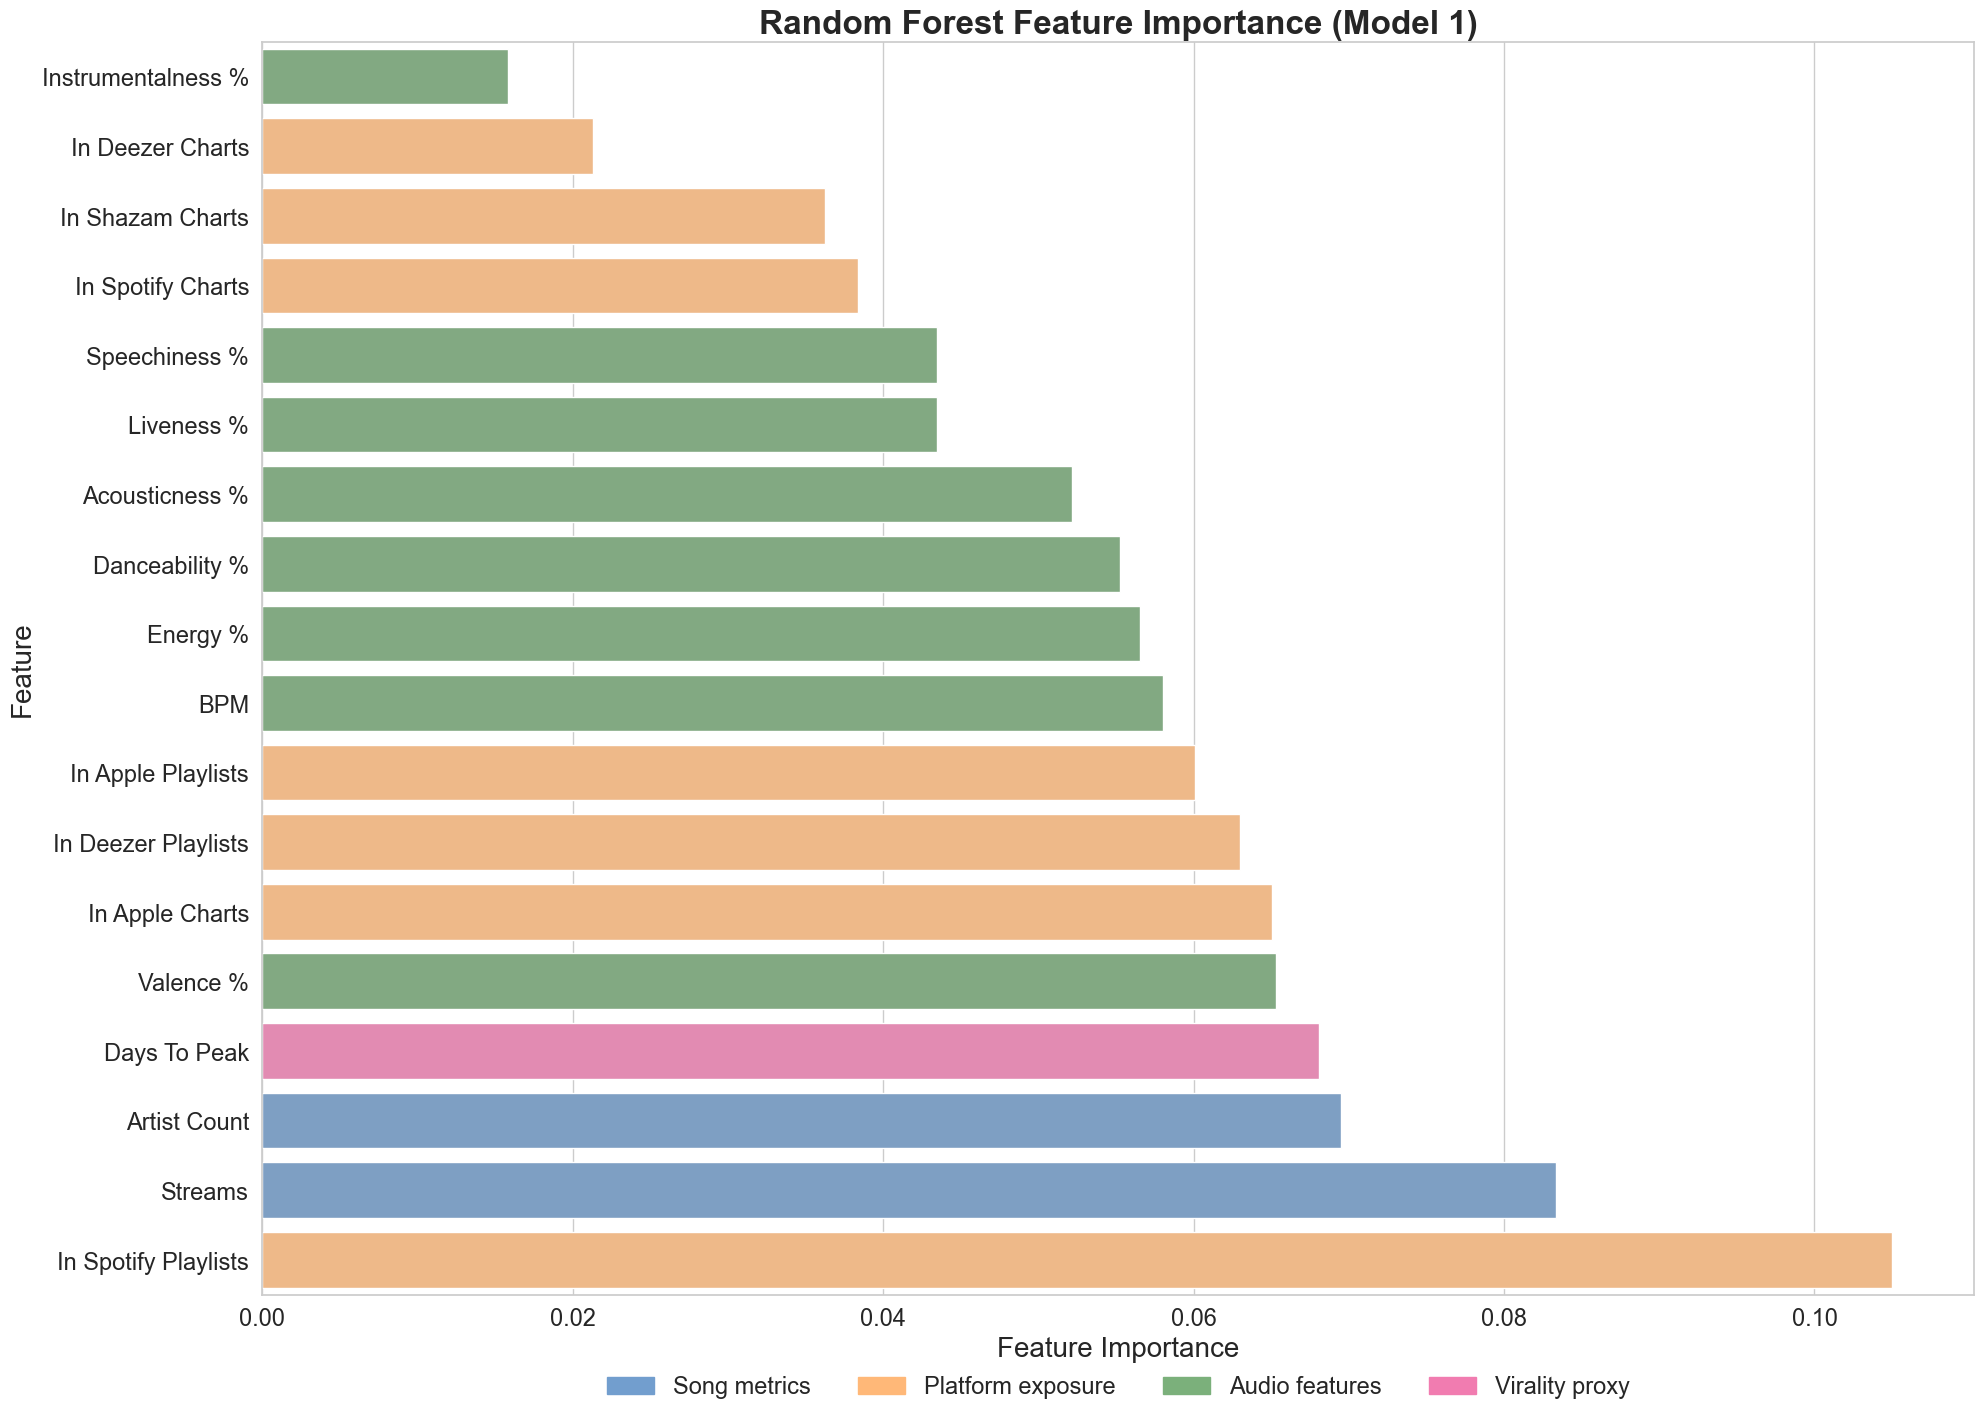

In [36]:
# Feature Importance

label_map = {
    'streams': 'Streams',
    'artist_count': 'Artist Count',
    'in_spotify_playlists': 'In Spotify Playlists',
    'in_spotify_charts': 'In Spotify Charts',
    'in_apple_playlists': 'In Apple Playlists',
    'in_apple_charts': 'In Apple Charts',
    'in_deezer_playlists': 'In Deezer Playlists',
    'in_deezer_charts': 'In Deezer Charts',
    'in_shazam_charts': 'In Shazam Charts',
    'bpm': 'BPM',
    'danceability_%': 'Danceability %',
    'valence_%': 'Valence %',
    'energy_%': 'Energy %',
    'acousticness_%': 'Acousticness %',
    'instrumentalness_%': 'Instrumentalness %',
    'liveness_%': 'Liveness %',
    'speechiness_%': 'Speechiness %',
    'days_to_peak': 'Days To Peak'
}

importances = model1.feature_importances_
feat_df = pd.DataFrame({'Feature': X1cols_model1, 'Importance': importances})
feat_df = feat_df.sort_values('Importance', ascending=True)
feat_df['Pretty Name'] = feat_df['Feature'].map(label_map)



color_map = {
    'Song metrics': '#729ECE',       # Soft Blue
    'Platform exposure': '#FFB878',  # Peachy Orange
    'Audio features': '#7BB07B',     # Muted Green
    'Virality proxy': '#F17CB0'      # Muted Pink
}

categories = {
    'Song metrics': ['streams', 'artist_count'],
    'Platform exposure': [
        'in_spotify_playlists', 'in_spotify_charts',
        'in_apple_playlists', 'in_apple_charts',
        'in_deezer_playlists', 'in_deezer_charts',
        'in_shazam_charts'
    ],
    'Audio features': [
        'bpm', 'danceability_%', 'valence_%', 'energy_%',
        'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'
    ],
    'Virality proxy': ['days_to_peak']
}

var_colors = {}
for cat, vars_in_cat in categories.items():
    for var in vars_in_cat:
        var_colors[var] = color_map[cat]

# Assign colors to sorted DataFrame
feat_df['Color'] = feat_df['Feature'].map(var_colors)

sns.set(style="whitegrid", palette="pastel")

plt.figure(figsize=(20, 15))
bars = sns.barplot(data=feat_df, x='Importance', y='Pretty Name', palette=feat_df['Color'].tolist())
plt.xlabel("Feature Importance", fontsize=20)
plt.ylabel("Feature", fontsize=20)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
plt.title("Random Forest Feature Importance (Model 1)", fontsize=24, weight='bold')

legend_patches = [mpatches.Patch(color=color, label=cat) for cat, color in color_map.items()]
plt.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=17, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1])  
plt.show()

In [26]:
# Model 2: Reduced Feature Set
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y1, test_size=0.2, random_state=42)

param_grid = {
    'max_depth': [10, 20, 30, 40],
    'n_estimators': [100, 200, 300, 400, 500]
}
# Create a based model
model = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 3 # number of folds for cross validation
                           , n_jobs = -1 # use all processors
                            , verbose = 2 # what to display
                          )

grid_search.fit(X2_train, y2_train)
model2 = grid_search.best_estimator_
y2_pred=model2.predict(X2_test)
print("Model 2 (Reduced Feature Set)")
print("Best Parameters:", model2)
print ('The out of sample test accuracy for a RandomForestClassifier is : '+ str(round(accuracy_score(y1_test, y1_pred),3)))
print ('MSE: ',mean_squared_error(y2_test, y2_pred))
print ('R2: ', r2_score(y2_test, y2_pred))
print(classification_report(y2_test, y2_pred))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.1s


/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 

[CV] END .....................max_depth=10, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=10, n_estimators=300; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=300; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=10, n_estimators=300; total time=   0.3s


/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 

[CV] END .....................max_depth=20, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=10, n_estimators=400; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=400; total time=   0.4s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=10, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.3s


/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 

[CV] END .....................max_depth=10, n_estimators=500; total time=   0.5s
[CV] END .....................max_depth=10, n_estimators=500; total time=   0.5s
[CV] END .....................max_depth=20, n_estimators=300; total time=   0.2s
[CV] END .....................max_depth=20, n_estimators=300; total time=   0.3s
[CV] END .....................max_depth=30, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=30, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=10, n_estimators=500; total time=   0.5s
[CV] END .....................max_depth=30, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=30, n_estimators=200; total time=   0.2s


/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 

[CV] END .....................max_depth=30, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=20, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=20, n_estimators=400; total time=   0.5s
[CV] END .....................max_depth=30, n_estimators=300; total time=   0.3s
[CV] END .....................max_depth=30, n_estimators=300; total time=   0.3s
[CV] END .....................max_depth=40, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=20, n_estimators=300; total time=   0.4s
[CV] END .....................max_depth=20, n_estimators=500; total time=   0.5s
[CV] END .....................max_depth=30, n_estimators=200; total time=   0.2s


/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 

[CV] END .....................max_depth=30, n_estimators=400; total time=   0.4s
[CV] END .....................max_depth=40, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=40, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=30, n_estimators=500; total time=   0.5s
[CV] END .....................max_depth=40, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=30, n_estimators=300; total time=   0.3s


/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 

[CV] END .....................max_depth=20, n_estimators=400; total time=   0.4s
[CV] END .....................max_depth=40, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=30, n_estimators=500; total time=   0.6s
[CV] END .....................max_depth=40, n_estimators=200; total time=   0.2s
[CV] END .....................max_depth=30, n_estimators=400; total time=   0.4s
[CV] END .....................max_depth=20, n_estimators=500; total time=   0.5s


/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 

[CV] END .....................max_depth=30, n_estimators=400; total time=   0.4s
[CV] END .....................max_depth=40, n_estimators=300; total time=   0.3s
[CV] END .....................max_depth=40, n_estimators=300; total time=   0.3s
[CV] END .....................max_depth=20, n_estimators=500; total time=   0.6s
[CV] END .....................max_depth=40, n_estimators=300; total time=   0.3s
[CV] END .....................max_depth=40, n_estimators=400; total time=   0.4s
[CV] END .....................max_depth=40, n_estimators=400; total time=   0.4s


/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END .....................max_depth=40, n_estimators=400; total time=   0.4s
[CV] END .....................max_depth=30, n_estimators=500; total time=   0.5s
[CV] END .....................max_depth=40, n_estimators=500; total time=   0.4s
[CV] END .....................max_depth=40, n_estimators=500; total time=   0.4s
[CV] END .....................max_depth=40, n_estimators=500; total time=   0.4s
Model 2 (Reduced Feature Set)
Best Parameters: RandomForestClassifier(max_depth=30, n_estimators=200)
The out of sample test accuracy for a RandomForestClassifier is : 0.723
MSE:  0.2513089005235602
R2:  -0.025732826135600684
              precision    recall  f1-score   support

           0       0.71      0.70      0.70        82
           1       0.77      0.79      0.78       109

    accuracy                           0.75       191
   macro avg       0.74      0.74      0.74       191
weighted avg       0.75      0.75      0.75       191



/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


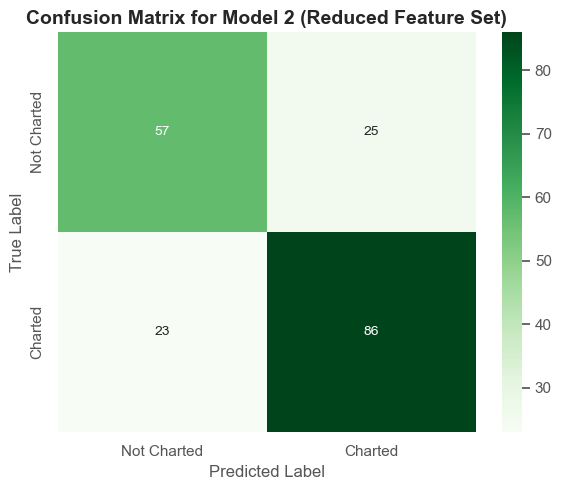

In [27]:
# Confusion matrix
cm = confusion_matrix(y2_test, y2_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Charted', 'Charted'], yticklabels=['Not Charted', 'Charted'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix for Model 2 (Reduced Feature Set)', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

/var/folders/wr/pk6811g13_57c07xqk29wvkm0000gn/T/ipykernel_77686/3669553230.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df_2, x='Importance', y='Pretty Name', palette=feat_df_2['Color'].tolist())


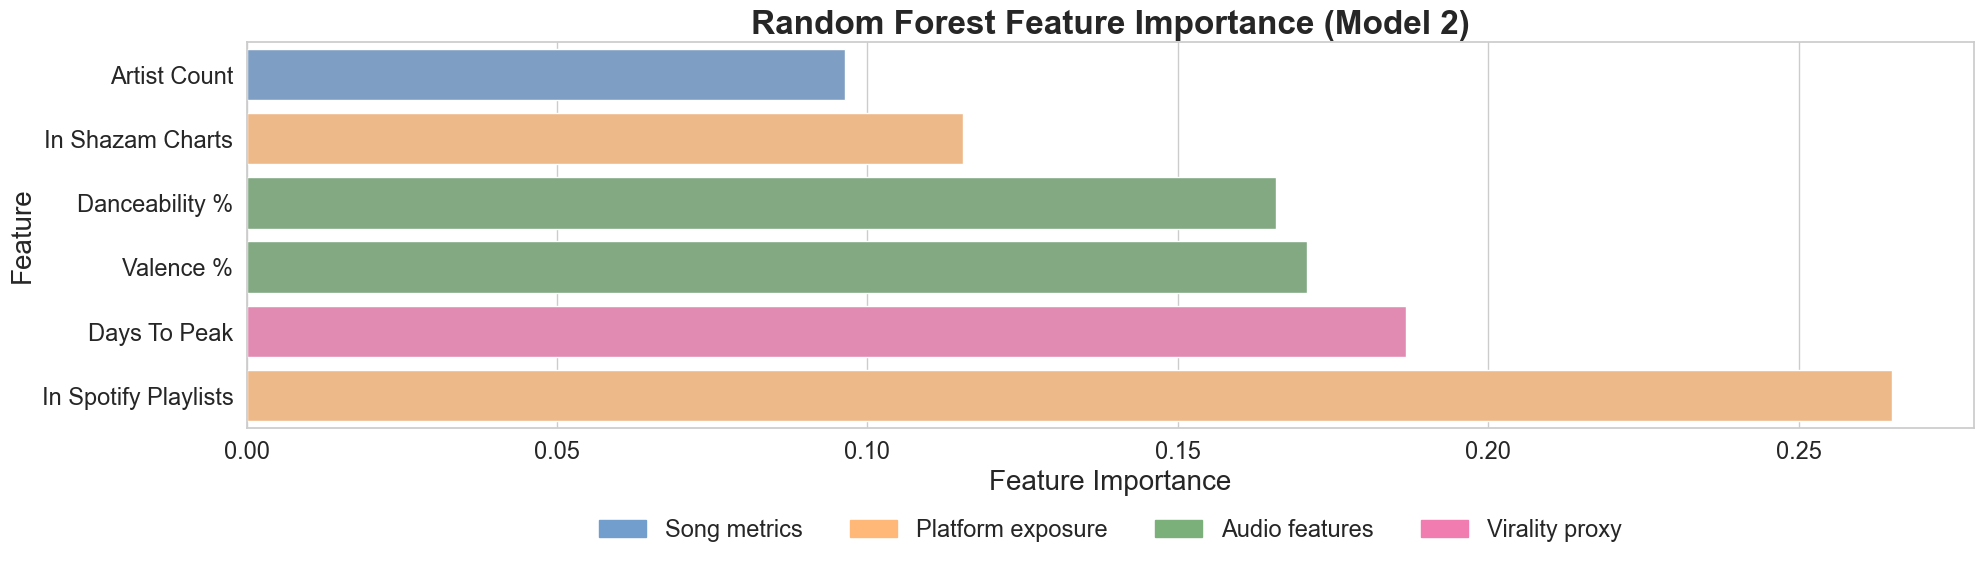

In [37]:
# Feature Importance

label_map_2 = {
    'artist_count': 'Artist Count',
    'in_spotify_playlists': 'In Spotify Playlists',
    'in_shazam_charts': 'In Shazam Charts',
    'danceability_%': 'Danceability %',
    'valence_%': 'Valence %',
    'days_to_peak': 'Days To Peak'
}

importances_2 = model2.feature_importances_
feat_df_2 = pd.DataFrame({'Feature': X1cols_model2, 'Importance': importances_2})
feat_df_2 = feat_df_2.sort_values('Importance', ascending=True)
feat_df_2['Pretty Name'] = feat_df_2['Feature'].map(label_map_2)

color_map_2 = {
    'Song metrics': '#729ECE',
    'Platform exposure': '#FFB878',
    'Audio features': '#7BB07B',
    'Virality proxy': '#F17CB0'
}

categories_2 = {
    'Song metrics': ['artist_count'],
    'Platform exposure': ['in_spotify_playlists', 'in_shazam_charts'],
    'Audio features': ['danceability_%', 'valence_%'],
    'Virality proxy': ['days_to_peak']
}

# Color mapping
var_colors_2 = {}
for cat, vars_in_cat in categories_2.items():
    for var in vars_in_cat:
        var_colors_2[var] = color_map_2[cat]


feat_df_2['Color'] = feat_df_2['Feature'].map(var_colors_2)

sns.set(style="whitegrid", palette="pastel")

# Plot
plt.figure(figsize=(20, 6.5))
sns.barplot(data=feat_df_2, x='Importance', y='Pretty Name', palette=feat_df_2['Color'].tolist())

plt.xlabel("Feature Importance", fontsize=20)
plt.ylabel("Feature", fontsize=20)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
plt.title("Random Forest Feature Importance (Model 2)", fontsize=24, weight='bold')

legend_patches_2 = [mpatches.Patch(color=color, label=cat) for cat, color in color_map_2.items()]
plt.legend(handles=legend_patches_2, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=4, fontsize=17, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

In [38]:
# Comparison using Performance Scores

report1 = classification_report(y1_test, y1_pred, output_dict=True)
report2 = classification_report(y2_test, y2_pred, output_dict=True)

# Grab relevant metrics for charted songs
metrics = ['accuracy', 'precision', 'recall', 'f1-score']
model1_scores = [
    report1['accuracy'],
    report1['1']['precision'],
    report1['1']['recall'],
    report1['1']['f1-score']
]

model2_scores = [
    report2['accuracy'],
    report2['1']['precision'],
    report2['1']['recall'],
    report2['1']['f1-score']
]


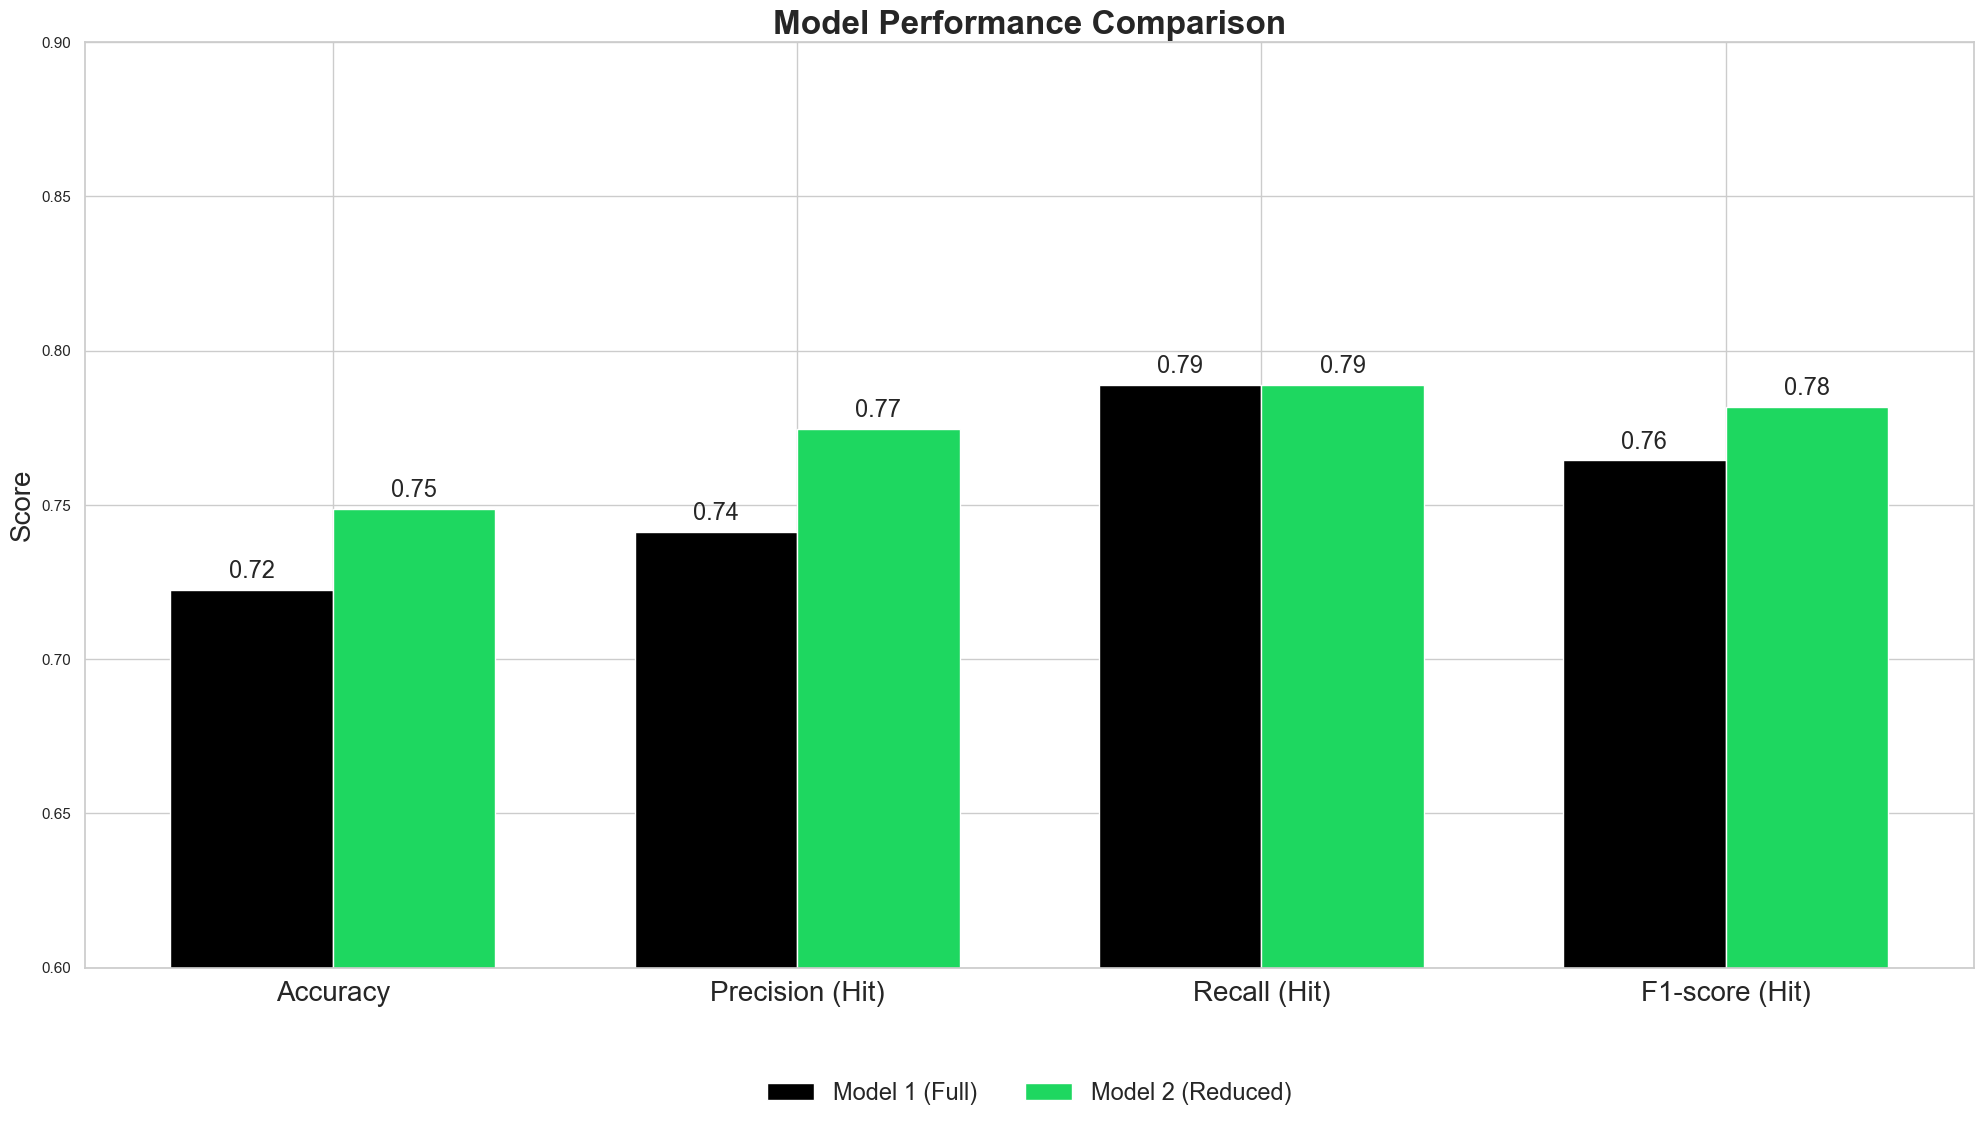

In [39]:
# Performance score figure

labels = ['Accuracy', 'Precision (Hit)', 'Recall (Hit)', 'F1-score (Hit)']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(20, 12))
bar1 = ax.bar(x - width/2, model1_scores, width, label='Model 1 (Full)', color='black')
bar2 = ax.bar(x + width/2, model2_scores, width, label='Model 2 (Reduced)', color='#1ED760')

ax.set_ylabel('Score', fontsize=20)
ax.set_title('Model Performance Comparison', fontsize=24, weight='bold') 
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=20)
ax.set_ylim(0.6, 0.9)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=False, fontsize=17)

# Add value labels
for bar in bar1 + bar2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=17)


plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()